In [2]:
import numpy as np
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_validation import train_test_split

import pandas as pd
from pickle import load, dump

from keras import metrics
import keras.backend as K
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.layers.merge import *
from keras.layers.convolutional import *
from keras.layers.embeddings import *
from keras.layers.wrappers import *
from keras.layers.normalization import *
from keras.layers.advanced_activations import *
from keras.models import *
from keras.callbacks import *
from keras.utils.vis_utils import *
from keras.utils import *

from IPython.display import SVG
import matplotlib.pyplot as plt

/home/wooya/.pyenv/versions/3.6.2/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [6]:
def read_data(path):
    Xs, Ys = pd.read_pickle(path)
    

    Xtrain, Xvalid, Xtest = Xs[:,:5725], Xs[:,5725:5725*2], Xs[:,5725*2:]
    
    Ys = np.concatenate([to_categorical(Ys[rowid])[None,:,:] for rowid in range(len(Ys))])
    Ytrain, Yvalid, Ytest = Ys[:,:5725], Ys[:,5725:5725*2], Ys[:,5725*2:]

    return Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest

In [7]:
num_marks = 5
length_bin = 100
num_filters = 50
length_filter = 10
length_pool = 5
length_full_1 = 625
length_full_2 = 125

In [8]:
Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest = read_data("../data/input.pkl")


In [9]:
print(f"train, X size: {Xtrain.shape}, Y size: {Ytrain.shape}")
print(f"test, X size: {Xvalid.shape}, Y size: {Yvalid.shape}")

train, X size: (2, 5725, 100, 5), Y size: (2, 5725, 2)
test, X size: (2, 5725, 100, 5), Y size: (2, 5725, 2)


# Model definition

In [12]:
%%time 
# channel last
input_shape = (length_bin, num_marks)
input = Input(shape=input_shape)

if K.image_data_format() == 'channels_first':
    channel_axis = 1
else:
    channel_axis = -1

def conv2d_bn(x, nb_filter, num_row,
              padding='same', strides=1, use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    x = Conv1D(nb_filter, num_row,
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x


def block_inception_a(input):
    branch_0 = conv2d_bn(input, 96, 1)

    branch_1 = conv2d_bn(input, 64, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3)

    branch_2 = conv2d_bn(input, 64, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3)

    branch_3 = AveragePooling1D(3, strides=1, padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_a(input):
    branch_0 = conv2d_bn(input, 384, 3, strides=2, padding='valid')

    branch_1 = conv2d_bn(input, 192, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, strides=2, padding='valid')

    branch_2 = MaxPooling1D(3, strides=2, padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_b(input):
    branch_0 = conv2d_bn(input, 384, 1)

    branch_1 = conv2d_bn(input, 192, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1)
    branch_1 = conv2d_bn(branch_1, 256, 7)

    branch_2 = conv2d_bn(input, 192, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7)
    branch_2 = conv2d_bn(branch_2, 224, 1)
    branch_2 = conv2d_bn(branch_2, 224, 7)
    branch_2 = conv2d_bn(branch_2, 256, 1)

    branch_3 = AveragePooling1D(3, strides=1, padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_b(input):
    branch_0 = conv2d_bn(input, 192, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, strides=2, padding='valid')

    branch_1 = conv2d_bn(input, 256, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1)
    branch_1 = conv2d_bn(branch_1, 320, 7)
    branch_1 = conv2d_bn(branch_1, 320, 3, strides=2, padding='valid')

    branch_2 = MaxPooling1D(3, strides=2, padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_c(input):
    branch_0 = conv2d_bn(input, 256, 1)

    branch_1 = conv2d_bn(input, 384, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1)
    branch_11 = conv2d_bn(branch_1, 256, 3)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3)
    branch_2 = conv2d_bn(branch_2, 512, 1)
    branch_20 = conv2d_bn(branch_2, 256, 1)
    branch_21 = conv2d_bn(branch_2, 256, 3)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling1D(3, strides=1, padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def inception_v4_base(input):
    net = conv2d_bn(input, 32, 3, strides=2, padding='valid')
    net = conv2d_bn(net, 32, 3, padding='valid')
    net = conv2d_bn(net, 64, 3)

    branch_0 = MaxPooling1D(3, strides=2, padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, strides=2, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1)
    branch_1 = conv2d_bn(branch_1, 64, 7)
    branch_1 = conv2d_bn(branch_1, 96, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, strides=2, padding='valid')
    branch_1 = MaxPooling1D(3, strides=2, padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)

    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)

    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net


def inception_v4(input, num_classes, dropout_keep_prob, include_top):
    '''
    Creates the inception v4 network
    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''
    
    # Make inception base
    x = inception_v4_base(input)


    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling1D(8, padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs, x, name='inception_v4')
    return model


clf = Model(inputs=input, outputs=inception_v4(input, 2, 0.5, True))
clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

ValueError: Negative dimension size caused by subtracting 8 from 1 for 'average_pooling1d_15/AvgPool' (op: 'AvgPool') with input shapes: [?,1,1,1536].

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 5)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 100, 50)           2550      
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 20, 50)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 20, 50)            25050     
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 50)            200       
__________

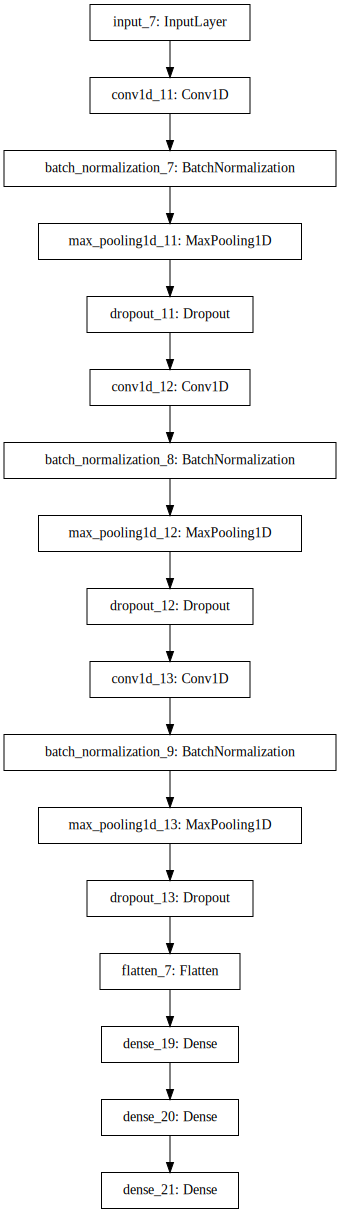

In [96]:
clf.summary()
SVG(model_to_dot(clf).create(prog='dot', format='svg'))

In [98]:
run_name = "deepchrome real new E013 2"
tb = TensorBoard(log_dir=f"../log/{run_name}", batch_size=32, write_graph=True)
checkpointer = ModelCheckpoint(filepath=f"../model/{run_name}.h5", verbose=1, save_best_only=True, monitor="val_acc")
stopper = EarlyStopping(monitor="val_acc", patience=3)

In [ ]:
epigenome = 0
clf.fit(
    Xtrain[epigenome],
    Ytrain[epigenome],
    batch_size=2000,
    callbacks = [tb, checkpointer],
    epochs=1000,
    shuffle=True,
    validation_data=(Xvalid[epigenome], Yvalid[epigenome]),
    verbose=0)

Epoch 00000: val_acc improved from -inf to 0.57659, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc improved from 0.57659 to 0.61380, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00003: val_acc improved from 0.61380 to 0.71878, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00004: val_acc improved from 0.71878 to 0.74463, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00005: val_acc improved from 0.74463 to 0.74725, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00006: val_acc improved from 0.74725 to 0.74882, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00007: val_acc improved from 0.74882 to 0.75511, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00008: val_acc improved from 0.75511 to 0.75983, saving model to ../model/deepchrome real new E013 2.h5
Epoch 00009: val_acc improved from 0.75983 to 0.76594, saving model to ../model/deepch